# Projekt 1 z Analizy Sygnałów - Karolina Milewska

Importuję potrzebne biblioteki

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.signal as ss
from scipy.io.wavfile import read

Wczytuję oba utwory tak, aby były tablicą numpy.

In [2]:
Fs_lily, syg_lily = read('Candy_Dulfer_-_Lily_Was_Here.wav')
Fs_world, syg_world = read('Rupert_Blaise_-_06_-_What_A_Wonderful_World.wav')

Przebieg tych sygnałów:

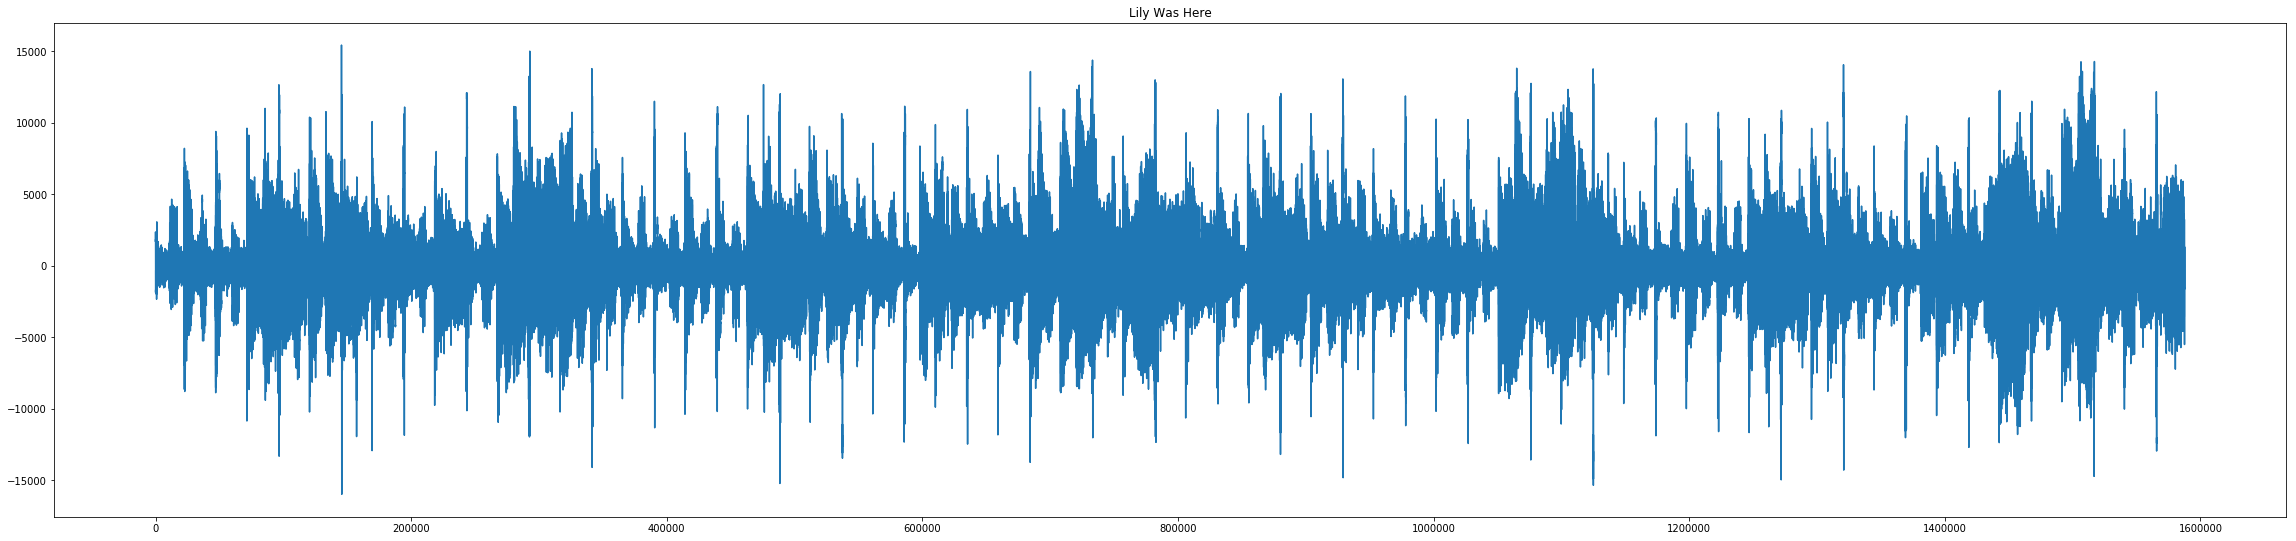

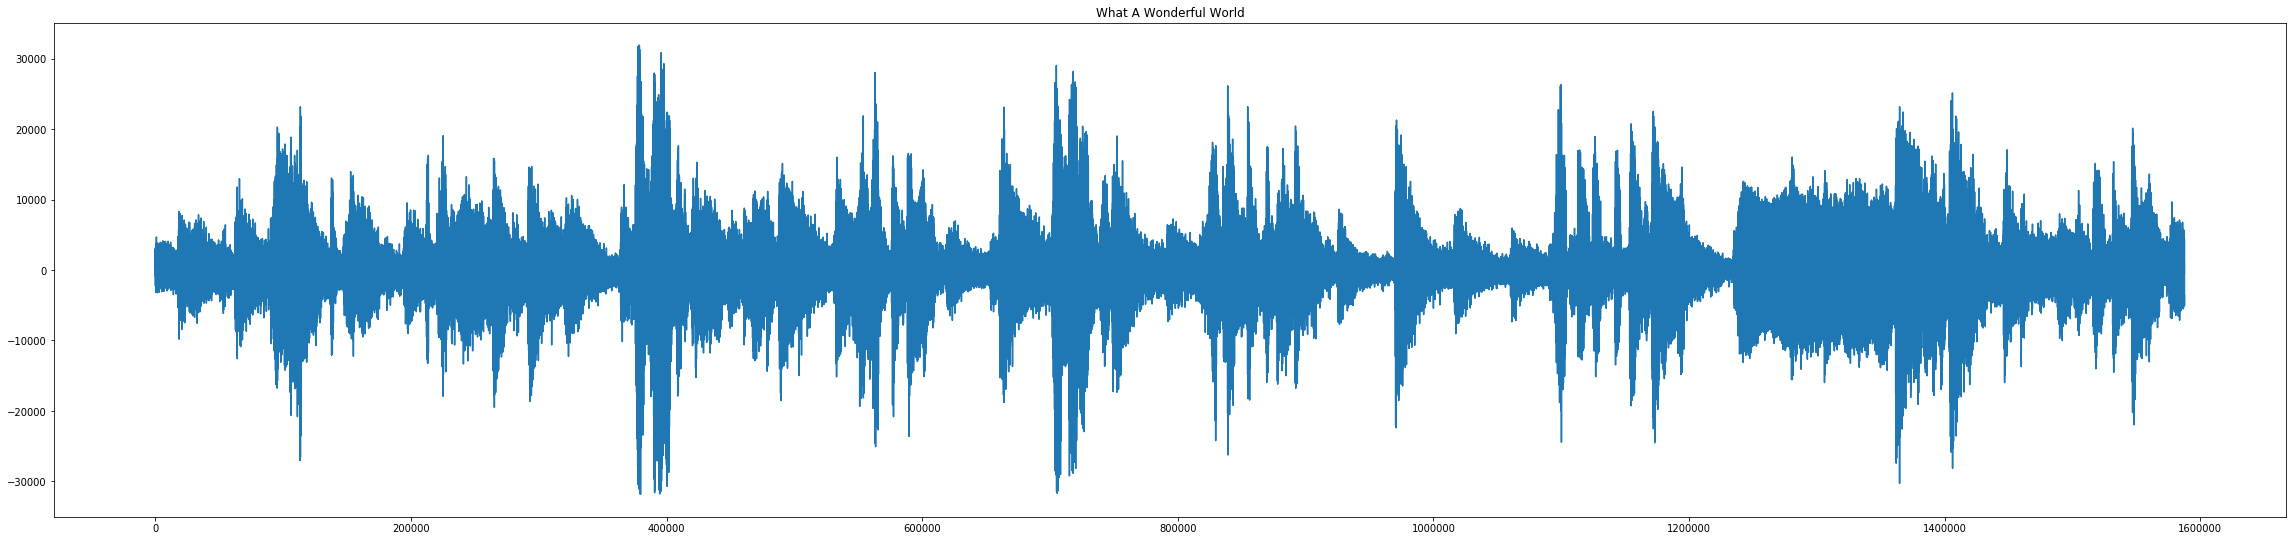

In [3]:
plt.figure(figsize = (40,20))
plt.subplot(2,1,1)
plt.title('Lily Was Here')
plt.plot(syg_lily)

plt.figure(figsize = (40,20))
plt.subplot(2,1,2)
plt.title('What A Wonderful World')
plt.plot(syg_world)
plt.show()

Tworzę funkcję periodogramu potrzebną do obliczenia widm mocy dla poszczególnych fragmetnów sygnału:

In [4]:
def periodogram (s, okno, Fs):
    okno /= np.linalg.norm(okno)
    s_zokienkowany = s * okno
    S = np.fft.rfft(s_zokienkowany)
    S_dB = 20 * np.log10(np.abs(S))
    P = S_dB * np.conj(S_dB)
    P = P/Fs
    P = np.real(P)

    if len(s)%2 == 0:
        P[1:-1] *= 2
    else:
        P[1:] *= 2
    
    F = np.fft.rfftfreq(len(s_zokienkowany), 1./Fs)
    
    return (F, P)

Tworzę funkcję, która ma za zadanie podzielić sygnał na konkretną ilość części o konkretnej długości i współczynniku nachodzenia się na siebie. N_wsp to część lub procent (zamieniony na ułamek dziesiętny) fragmentu, który nam będzie nachodzić na poprzedni - stopień nachodzenia. W moim przypadku N_wsp będzie przyjmować wartości pomięzy 0 a 1. Jeśli nie chcemy, aby fragmenty sygnału się na siebie nachodziły to N_wsp musi być równe 0 lub 1, dla obu tych wartości funkcja będzie działać i uzyskamy dokładnie ten sam efekt. Domyślnie będzie wpisana 1.

In [5]:
def dzieli_sygnal (s, N_okna, N_wsp = 1):
    sygnal_cz = [] #lista, w której będziemy zapisywać tablice liczb o długości N_okna, odpowiadające kolejny podziałom sygnału
    N = int(N_okna*N_wsp) # część wspólna dwóch sygnałów

    if N_wsp == 1: # fragmenty nie nachodzą się na siebie
        N_fr = int((len(s) - N_okna)//N_okna) # całkowita ilość fragmentów sygnału o długości N_okna i N_wsp = 1
        
        for i in range (N_fr):
            sygnal_cz.append (s[(i)*N_okna:(i+1)*N_okna])
        
    else: # fragmenty mogą na siebie nachodzić
        N_fr = int((len(s) - N_okna)//(N_okna - N)) # całkowita ilość fragmentów sygnału o długosci N_okna i wspólczynniku 
                                                    # nachodzenia N_wsp, dla N_wsp = 0 sygnał jest dzielony bez nachodzenia 
                                                    # fragmentów, tak samo jak dla N_wsp = 1
        for i in range (N_fr+1): 
            sygnal_cz.append (s[i*(N_okna-N): (i+1)*N_okna-i*N])
       
    return sygnal_cz, N_fr # zwracamy podzielony sgynał s w postaci listy, gdzie każdy element listy to tablica liczb o 
                             # długości N_okna, oraz zwracamy całkowitą liczbę fragmentów na ktory podzieliliśmy sygnał

Mając już funkcję na dzielenie sygnału na kawałki o konkretnej długości, tworzę funkcję, która będzie bezpośrednio nam rysować spektrogram sygnału.

In [24]:
def spektrogram (s, N_okna, N_wsp, okno, Fs, t_min, t_max, f_min, f_max, tytul):
    # spekrogram
    s = s[(Fs*t_min):(Fs*t_max)] # warunki na zakres czasu
    syg_cz, N_fr = dzieli_sygnal (s, N_okna, N_wsp)
    spect = np.zeros ((int((N_okna / 2) + 1), N_fr)) # macierz, wktórej będziemy przechowywać w i-tej kolumnie widmo i-tego 
                                                     # fragment    
    for n in range (N_fr):
        f, spect[:,n] = periodogram (syg_cz[n], okno, Fs)

    # warunki na zakres częstotliwości
    N_f = N_okna/2
    f_odstep = (Fs/2)/N_f # rozdzielczość częstości
    idx_min = int(f_min/f_odstep) # indeks dolny
    idx_max = int(f_max/f_odstep) # indeks górny
    spect = spect [idx_min:idx_max,:]
    
    # moc sygnału w czasie
    P = np.zeros(len(s))
    t = np.arange (t_min, t_max, 1./Fs)
    
    for i in range(len(s)):  
        P[i] = s[i]**2
   
    # widmo mocy
    okno_syg = np.ones (len(s))
    F, p = periodogram (s, okno_syg, Fs)
    
    N = len(s)/2
    f_odstep2 = (Fs/2)/N
    idx_min2 = int(f_min/f_odstep2) 
    idx_max2 = int(f_max/f_odstep2)
    F = F[idx_min2:idx_max2]
    p = p[idx_min2:idx_max2]
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2], height_ratios=[4, 1]) # robimy niestandardowego subplota
    
    plt.figure(figsize = (10,8))
    plt.subplot(gs[1])
    
    plt.title(tytul)
    plt.xlabel('Czas [s]')
    #plt.ylabel('Częstotliwość [Hz]') # tytuł osi y nachodził wykres, a jets taki sam jak tytuł osi y widam mocy, więc 
                                      # zostawiłam tylko jeden podpis
    plt.imshow(spect, aspect = 'auto', origin = 'lower', extent = [t_min, t_max, f_min, f_max], vmin = 0.1, vmax = 0.35)

    plt.subplot(gs[3])    
    plt.xlabel('Czas [s]')
    plt.ylabel('Moc [W]')
    plt.plot(t, P)
    
    plt.subplot(gs[0])
    plt.ylabel('Częstotliwość [Hz]')
    plt.xlabel('Moc [W]')
    plt.gca().invert_xaxis()
    plt.plot(p, F)
    plt.show()

In [28]:
N_okna = 128
N_wsp = 1

#okno = np.ones (N_okna)
okno = ss.blackman (N_okna)
#okno = ss.hamming (N_okna)
#okno = ss.hann (N_okna)

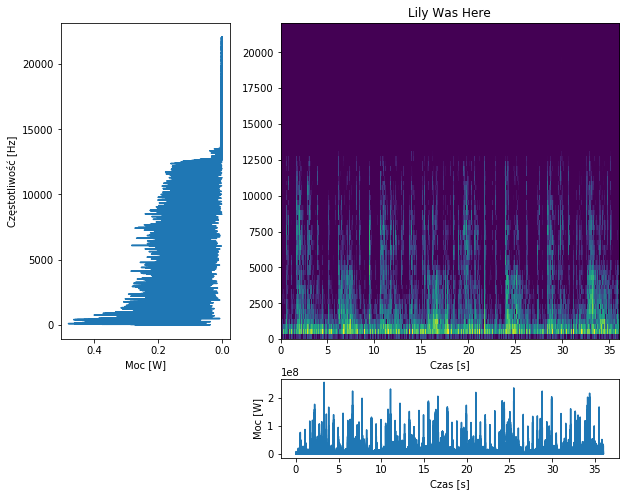

In [29]:
spektrogram (syg_lily, N_okna, N_wsp, okno, Fs_lily, 0, 36, 0, Fs_lily/2, 'Lily Was Here')

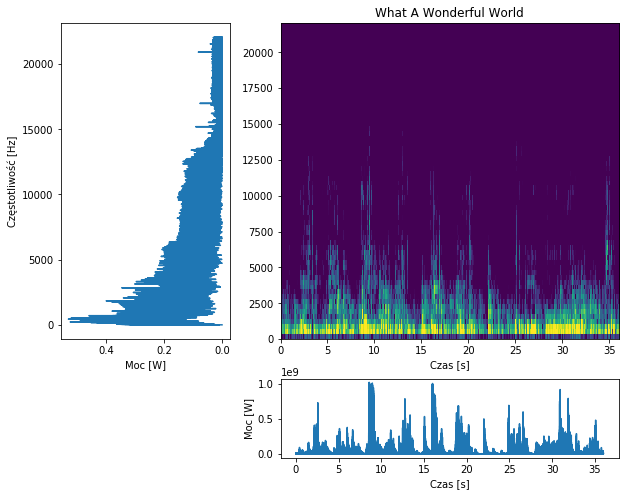

In [30]:
spektrogram (syg_world, N_okna, N_wsp, okno, Fs_world, 0, 36, 0, Fs_world/2, 'What A Wonderful World')

Dla krótszych okienek uzyskujemy mniej szczegółowy spektrogram - im dłuższe okienko tym więcej możemy się do wiedzieć o utworze z samego wykresu.

Dla różnych okienek nasz spektrogram wygląda bardzo podobnie, zwłaszcza jeśli porównamy wyniki dla okienka Blackmana, Hamminga oraz Hanna (bardzo małe różnice między spektrogramami), natomiast widoczne różnice zauważymy między okienkiem prostokątnym a innymi okienkami. Widać, że dla okna prostokątnego dostajemy dużo 'pionowych linii' w konkretnych momentach czasu, które się ciągną przez cały zakres częstotliwości. Inne okienka nam je wycinają i dostajemy klarowny spektrogram.

Dla piosenki pt. "Lily Was Here" wyraźnie widzimy, że mamy 'najwięcej' dźwięków o niskich częstotliwościach (zakres ok. 500Hz - 1500Hz). Po odsłuchaniu utworu słyszymy, że to co odczytaliśmy ze spektrogamu zgadza się z tym co słyszymy (głównie melodia saksofonu). 

Dla piosenki pt. "What A Wonderful World", tak jak poprzednio najwięcej mamy dźwięków o niskich częstotliowściach (500Hz - 1000Hz). Jest ich dużo więcej niż w poprzedniej piosence. Jest to spowodowane tym, że w pierwszym utworze mieliśmy same instrumenty, a w drugim mamy jeszcze dodatkowo wokal. Wyraźnie widać, że w drugim utworze dla niskich częstotliwości mamy melodię pianina oraz wokal.